In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt

In [2]:

print(torch.cuda.is_available())

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

path = "../Data/MNIST/"

True


In [3]:
preprocessor = transforms.Compose([
    transforms.Resize(32),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

In [4]:
def get_data():
    train_set = datasets.ImageFolder(path+'train/', transform=preprocessor)
    val_set = datasets.ImageFolder(path+'val/', transform=preprocessor)
    test_set = datasets.ImageFolder(path+'test/', transform=preprocessor)
    train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True, num_workers=2, drop_last=True, pin_memory=True)
    val_loader = DataLoader(dataset=val_set, batch_size=128, num_workers=2, drop_last=True)
    test_loader = DataLoader(dataset=test_set, batch_size=64, num_workers=2, drop_last=True)
    # train_loader = 0
    return train_loader, val_loader, test_loader

In [5]:
train, val, test = get_data()
trainiter = iter(train)
nex = next(trainiter)


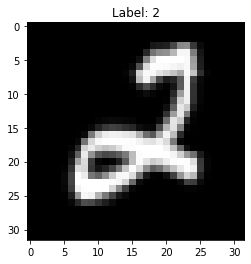

In [6]:

img = nex[0][0].numpy().reshape(32, 32, 1)
plt.title('Label: ' + str(nex[1][0].item()))
plt.imshow(img, cmap='gray')

In [7]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    out = model(xb)
    loss = loss_func(out, yb)
    preds = torch.argmax(out, dim=1)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), len(xb), (preds == yb).float().mean()

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        print('-'*10)
        model.train()
        for xb, yb in train_dl:
            xb = xb.to(dev)
            yb = yb.to(dev)
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums, accuracy = zip(*[loss_batch(model, loss_func, xb.to(dev), yb.to(dev)) for xb, yb in valid_dl])

        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        accuracy = np.sum(accuracy)/len(accuracy)
        print("Accuracy: " + str(accuracy.item()))

        print('Epoch: ' + str(epoch+1) + ' loss: ' + str(val_loss) + '\n')

def test_single_batch(epochs, model, loss_func, opt, xb, yb):
    for epoch in range(epochs):
        if (epoch+1) % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs}")
        model.train()

        xb = xb.to(dev)
        yb = yb.to(dev)
        loss_batch(model, loss_func, xb, yb, opt)

        if (epoch+1) % 100 == 0:
            model.eval()
            with torch.no_grad():
                print(loss_batch(model, loss_func, xb, yb))

In [8]:

class ViewLayer(torch.nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

model = torch.nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Dropout2d(0.2),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    ViewLayer(lambda x: x.view(x.size(0), -1)),
)

In [9]:
opt = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_func = torch.nn.CrossEntropyLoss()
model.to(dev)
xb, yb = trainiter.next()
# test_single_batch(10000, model, loss_func, opt, xb, yb)
fit(20, model, loss_func, opt, train, val)

Epoch 1/20
----------
Accuracy: 0.6456745266914368
Epoch: 1 loss: 1.0977501760168773
Epoch 2/20
----------
Accuracy: 0.7845845818519592
Epoch: 2 loss: 0.6651253089672182
Epoch 3/20
----------
Accuracy: 0.8424161076545715
Epoch: 3 loss: 0.5056012082935833
Epoch 4/20
----------
Accuracy: 0.8980563879013062
Epoch: 4 loss: 0.34741120939938036
Epoch 5/20
----------
Accuracy: 0.8986279964447021
Epoch: 5 loss: 0.3465140980282208
Epoch 6/20
----------
Accuracy: 0.9140624403953552
Epoch: 6 loss: 0.2968954877337305
Epoch 7/20
----------
Accuracy: 0.9213985800743103
Epoch: 7 loss: 0.27113024286198906
Epoch 8/20
----------
Accuracy: 0.9294016361236572
Epoch: 8 loss: 0.25007588466311376
Epoch 9/20
----------
Accuracy: 0.9297827482223511
Epoch: 9 loss: 0.24186919329733383
Epoch 10/20
----------
Accuracy: 0.9307354688644409
Epoch: 10 loss: 0.2360647057705536
Epoch 11/20
----------
Accuracy: 0.934165358543396
Epoch: 11 loss: 0.22670792799624728
Epoch 12/20
----------
Accuracy: 0.9349275827407837
Epoch